In [ ]:
import pandas as pd
import numpy as np
# from relative_fitness_mechanisms.selective_pressure_prediction import (create_lagged_features, 
#                                                                        process_inputs_all, 
#                                                                        withhold_test_locations_and_split)


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import string

In [2]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from selective_pressure_prediction import (create_lagged_features, 
                                           process_inputs_all, 
                                            withhold_test_locations_and_split)

In [ ]:
#selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases_full.tsv", sep="\t")
selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases.tsv", sep="\t")

selective_pressure_df["date"] = pd.to_datetime(selective_pressure_df["date"])
selective_pressure_df = selective_pressure_df.dropna()

In [ ]:
input_dfs = {}
TARGET = "empirical_growth_rate"
keep_features = ["date", "location", "selective_pressure"]
keep_targets = [TARGET]

# Create lagged features by group
for loc, group in selective_pressure_df.groupby("location"):
    input_dfs[loc] = create_lagged_features(
        group[keep_features + keep_targets], 
        ["selective_pressure"], 
        28)

In [ ]:
WITHHELD_LOCATIONS = ["England"]
dates_vec, locations_vec, X, y = process_inputs_all(input_dfs, target=TARGET)
X_train, y_train, X_test, y_test = withhold_test_locations_and_split(X, y, locations_vec, WITHHELD_LOCATIONS)

In [145]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [153]:
# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1e-2),
    'Lasso': Lasso(alpha=1e-6),
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'GradientBoostingA': GradientBoostingRegressor(loss="absolute_error", n_estimators=100, max_depth=3),
    'GradientBoostingB': GradientBoostingRegressor(loss="absolute_error", n_estimators=100, max_depth=5),
    'GradientBoostingC': GradientBoostingRegressor(loss="absolute_error", n_estimators=200, max_depth=7),

}
model_scores = {model: [] for model in models}

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform time series cross-validation for model selection
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize and train your linear model within each split
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        mse = mean_squared_error(y_val, predictions)
        
        # Append the MSE to the model's list of scores
        model_scores[model_name].append(mse)

for model_name, scores in model_scores.items():
    print(f"{model_name}: Mean MSE = {np.mean(scores):.4f}, Std MSE = {np.std(scores):.4f}")
    
best_model_name = min(model_scores, key=lambda k: np.mean(model_scores[k]))

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.396e-03, tolerance: 3.300e-04
  model = cd_fast.enet_coordinate_descent(
/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.473e-04, tolerance: 4.598e-04
  model = cd_fast.enet_coordinate_descent(
/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-p

LinearRegression: Mean MSE = 0.0076, Std MSE = 0.0064
Ridge: Mean MSE = 0.0051, Std MSE = 0.0032
Lasso: Mean MSE = 0.0049, Std MSE = 0.0032
RandomForest: Mean MSE = 0.0027, Std MSE = 0.0009
GradientBoostingA: Mean MSE = 0.0024, Std MSE = 0.0007
GradientBoostingB: Mean MSE = 0.0024, Std MSE = 0.0009
GradientBoostingC: Mean MSE = 0.0025, Std MSE = 0.0008


In [154]:
# Retrain best model
best_model = models[best_model_name]
best_model.fit(X, y)
predictions = best_model.predict(X_test)

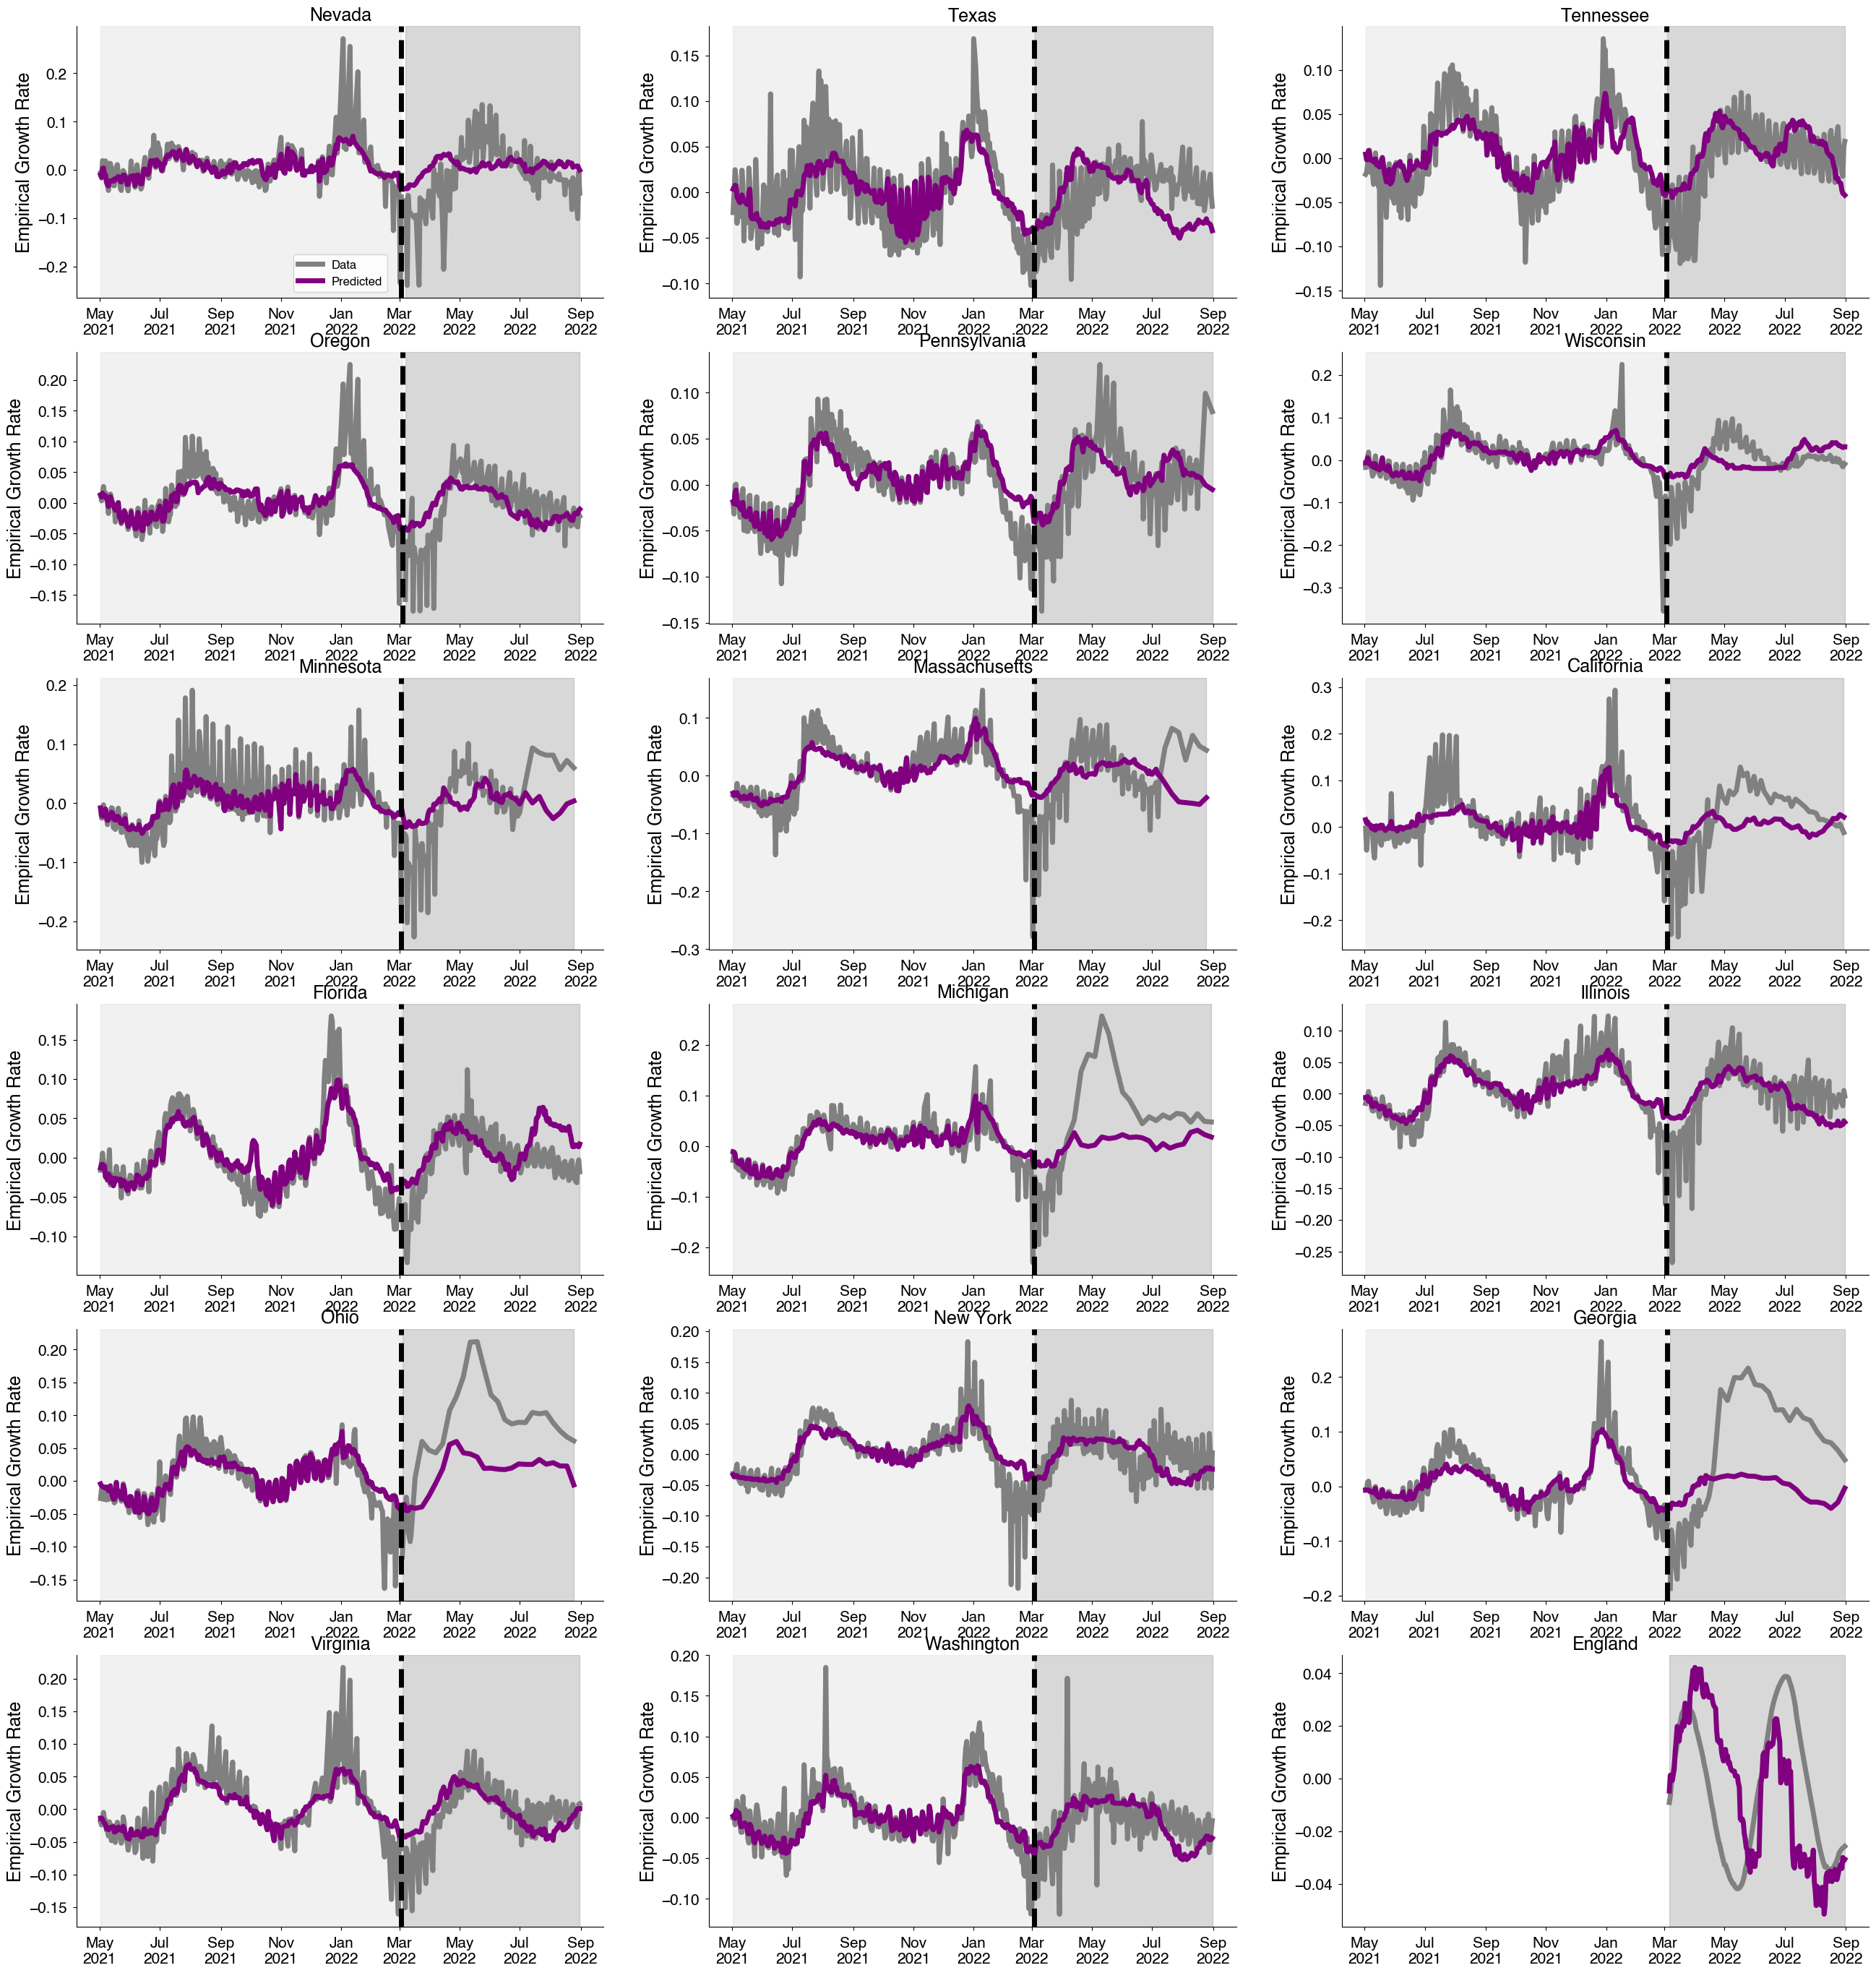

In [155]:
def plot_yeqx(ax):
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        return None
    
locations = selective_pressure_df["location"].unique()
fig = plt.figure(figsize=(32, 40))
spec = fig.add_gridspec(ncols=3, nrows=len(locations) // 3 + 1)

for l, loc in enumerate(locations):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color="grey", label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color="grey")
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color="purple", label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color="purple")
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color="lightgrey", alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color="grey", alpha=0.3)

    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()

#fig.savefig("figures/empirical-growth-rate-predictions.png")

In [158]:
# Subset locations
locations_subset = ["California",   "Michigan", "Nevada", "New York", "Texas", "Washington"]
target_locations = ["England"]

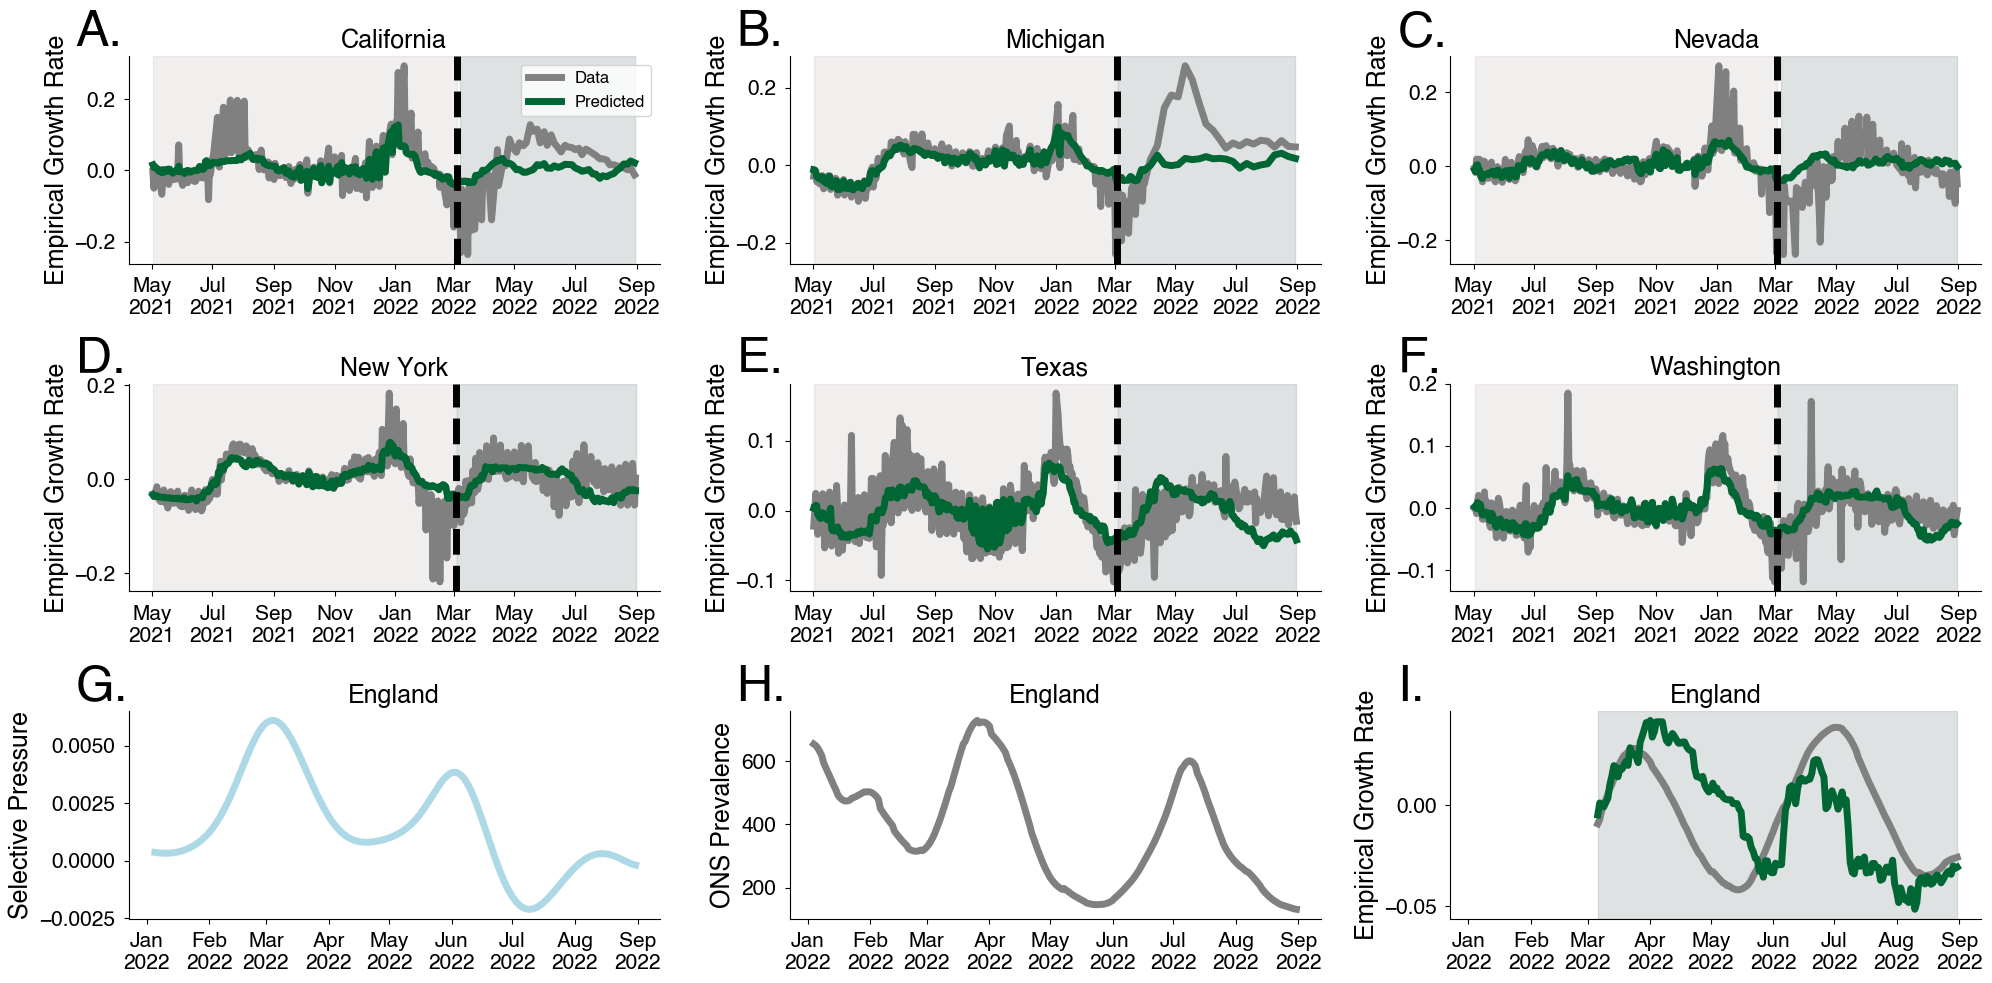

In [159]:
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(ncols=3, nrows=len(locations_subset) // 3 + 1)

TRAIN_PERIOD_COLOR, TEST_PERIOD_COLOR = "#d1c7c9", "#949fa5"
PREDICTION_COLOR = "#006633"
DATA_COLOR = "grey"

data = {loc: df for loc, df in selective_pressure_df.groupby("location")}
axes = []

for l, loc in enumerate(locations_subset):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()
    axes.append(ax)
    
# Add in target_locations
last_l = l
for l, loc in enumerate(target_locations):
    
    # Add selective pressure
    _l = 0
    ax = fig.add_subplot(spec[-1, 0], sharex=None if _l==0 else ax)
    _, selective_pressure = compute_selective_pressure(posteriors[loc])
    ax.plot(data[loc].dates, selective_pressure, color="lightblue")
    ax.set_ylabel("Selective Pressure")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
    
    # Add prevalence
    ax = fig.add_subplot(spec[-1, 1], sharex = ax)
    t_cases = [t for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    ax.plot(t_cases, cases[loc].cases, color="gray")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.set_ylabel("ONS Prevalence")
    axes.append(ax)
   
    # Add predictions
    ax = fig.add_subplot(spec[-1, -1], sharex=ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]
    
    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)

ax_labels = string.ascii_uppercase 
for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
fig.tight_layout()


# TODO: Could add part that has variant frequencies
fig.savefig("../manuscript/figures/selective_pressure_prediction.png")